# Testing notebook for GGL IA halo model

In [287]:
import pyccl as ccl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import simps
from scipy.interpolate import interp1d
from importlib import reload

import CM_code.halo_model as halos 
import CM_code.spurious_george as sp

reload(sp)
reload(halos)

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['cmr10']
plt.rcParams['mathtext.fontset'] ='cm'
plt.rc('axes', unicode_minus=False)
plt.rc('axes.formatter', use_mathtext=True)

### Set up halo models for sattelite intrinsic shear & lens occupation

In [2]:
cosmo = halos.zed.cosmo_SRD

# defined to be same as in boost function
k_arr = np.geomspace(1E-4, 5E4, 3000)

# define scale factors for Pk2D to inteprolate between
a_arr = np.linspace(0.1,1,32)

In [3]:
# Here we use a mass definition with Delta = 200 times the matter density,
hmd_200m = ccl.halos.MassDef200m()

# the Duffy 2008 concentration-mass relation,
cM = ccl.halos.ConcentrationDuffy08(hmd_200m)

# the Tinker 2010 halo mass function,
nM = ccl.halos.MassFuncTinker10(cosmo, mass_def=hmd_200m)

# the Tinker 2010 halo bias,
bM = ccl.halos.HaloBiasTinker10(cosmo, mass_def=hmd_200m)

# and the halo model calculator object.
hmc = ccl.halos.HMCalculator(cosmo, nM, bM, hmd_200m, nlog10M=64)

In [4]:
# create a sattelite shear HOD based on perscription of Fortuna 2021
sat_gamma_HOD = ccl.halos.SatelliteShearHOD(halos.cM, a1h=0.001, b=-2)

### Compute lens-SatteliteShear power spectrum for 1h term

In [514]:
# NFW profile for matter (G)
NFW =  ccl.halos.HaloProfileNFW(cM, truncated=True, fourier_analytic=True)

# Nicola HOD profile for galaxy occupation
LensHOD = ccl.halos.HaloProfileHOD(cM)

# NOTE: Do not set normprof = True for the satellite shear; this is taken care of internally.
pk2d_II_1h = ccl.halos.halomod_Pk2D(cosmo, hmc, sat_gamma_HOD,
                                    normprof1 = False,
                                    get_2h = False,
                                    lk_arr = np.log(k_arr),
                                    a_arr = a_arr)

pk2d_gg_1h = ccl.halos.halomod_Pk2D(cosmo, hmc, LensHOD, 
                                    prof_2pt=halos.HOD2pt, prof2=LensHOD, 
                                    normprof1=True, normprof2=True,
                                    get_2h = False,
                                    lk_arr=np.log(k_arr), a_arr=a_arr
                                    )

pk2d_gg_2h = ccl.halos.halomod_Pk2D(cosmo, hmc, LensHOD, 
                                    prof_2pt=halos.HOD2pt, prof2=LensHOD, 
                                    normprof1=True, normprof2=True,
                                    get_1h = False,
                                    lk_arr=np.log(k_arr), a_arr=a_arr
                                    )

### Compute NLA lens-IntrinsicShear power spectrum for 2h term

In [516]:
# read in luminosity function NLA amplitudes and redshifts
df = pd.read_csv('niko_ia_amp_redfrac.csv')

df = df[df['z'] >= sp.zed.zs_min]
df = df[df['z'] <= sp.zed.zs_max]

z_IA = np.asarray(df['z'])
A_IA = np.asarray(df['ia_amp_y1'])
interp_A_IA = interp1d(z_IA, A_IA, fill_value='extrapolate')

# create galaxy matter power spectrum 
pk_gI_NLA = np.empty((len(a_arr), len(k_arr)))
for i,a in enumerate(a_arr):
    # get z of a 
    z_a = (1./a) - 1.
    
    # get alignment amplitude at corresponding z_a
    A_NLA = 1#interp_A_IA(z_a)
    C1 = 5e-14
    C1tilde = A_NLA * C1 * cosmo['Omega_m'] * (ccl.physical_constants.RHO_CRITICAL 
                                           / ccl.background.growth_factor(cosmo, 1))
    
    # compute galaxy-intrinsic power spectrum at a
    pk_II_NLA = C1tilde**2 * ccl.nonlin_matter_power(cosmo, k_arr, a)
    
    #pk_gI_NLA[i,:] = -np.sqrt(pk_II_NLA * pk2d_gg_2h.eval(k_arr, a, cosmo))
    pk_gI_NLA[i,:] = -C1tilde * 1.05 * ccl.nonlin_matter_power(cosmo, k_arr, a)
    
pk2d_gI_NLA = ccl.pk2d.Pk2D(a_arr=a_arr, 
                            lk_arr=np.log(k_arr), 
                            pk_arr=pk_gI_NLA, 
                            is_logp=False)

### Window power spectra to prevent dobule counting in transition scales

In [517]:
pk_gI_windowed = np.empty((len(a_arr), len(k_arr)))
pk_gI_1h = np.empty((len(a_arr), len(k_arr)))
k1h = 4*cosmo['h'] #1/Mpc
k2h = 6*cosmo['h'] #1/Mpc

for i,a in enumerate(a_arr):
    pk_gI_windowed[i,:] = (-np.sqrt(pk2d_II_1h.eval(k_arr, a, cosmo) 
                                   * pk2d_gg_1h.eval(k_arr, a, cosmo))
                           * (1-np.exp(-(k_arr/k1h)**2)) 
                           + pk2d_gI_NLA.eval(k_arr, a, cosmo) 
                           * np.exp(-(k_arr/k2h)**2))
    
    pk_gI_1h[i,:] = -np.sqrt(pk2d_II_1h.eval(k_arr, a, cosmo) 
                                   * pk2d_gg_1h.eval(k_arr, a, cosmo))
    
pk2d_gI_windowed = ccl.pk2d.Pk2D(a_arr=a_arr, lk_arr=np.log(k_arr), 
                                 pk_arr=pk_gI_windowed, is_logp=False)
                             
pk2d_gI_1h = ccl.pk2d.Pk2D(a_arr=a_arr, lk_arr=np.log(k_arr), 
                                 pk_arr=pk_gI_1h, is_logp=False)

Text(0.5, 0, '$k$ ($\\rm{Mpc}^{-1}$)')

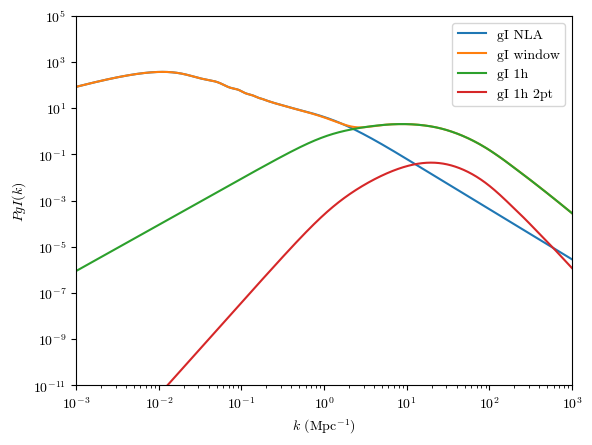

In [518]:
plt.figure()
# plt.loglog(k_arr, pk2d_II_1h.eval(k_arr, 1., cosmo), label='II 1h')
# plt.loglog(k_arr, pk2d_gg_1h.eval(k_arr, 1., cosmo), label='gg 1h')
plt.loglog(k_arr, -pk2d_gI_NLA.eval(k_arr, 1., cosmo), label='gI NLA')
plt.loglog(k_arr, -pk2d_gI_windowed.eval(k_arr, 1., cosmo), label='gI window')
plt.loglog(k_arr, -pk2d_gI_1h.eval(k_arr, 1., cosmo), label='gI 1h')
plt.loglog(k_arr, pk2d_gI_2pt.eval(k_arr, 1., cosmo), label='gI 1h 2pt')
plt.legend()
plt.xlim([1e-3, 1e3])
plt.ylim([1e-11, 1e5])
plt.ylabel(r'$PgI(k)$')
plt.xlabel(r'$k$ ($\rm{Mpc}^{-1}$)')

### Load in lens-source redshift data and 2D binning

In [519]:
# load in redshift data
zlmin, zlmax = 1.0, 1.2

_, _, zleff = sp.zed.get_dndz_spec(gtype='lens', zlmin=zlmin, zlmax=zlmax, year=1)
z_s, dndz_s, *_ = sp.zed.get_dndz_phot(gtype='source', year=1)
z_l, dndz_l, *_ = sp.zed.get_dndz_phot(gtype='lens', zlmin=zlmin, zlmax=zlmax, year=1)

B_min1 = np.load('generated_data/boost_y1_highZ.npz')['B_min1']
F_theta = sp.get_F(theta_dependence=True)
r_p = np.load('generated_data/boost_y1_highZ.npz')['rp']

theta = sp.rp_to_arcmin(r_p, zleff)
#theta = np.logspace(np.log10(0.01), np.log10(10), 300)

### Compute angular power spectra for 1-halo and NLA

In [520]:
# set ell values based on theta range
ell = np.unique(np.geomspace(180/(theta[-1]/60.) - 10, 
                             180/(theta[0]/60.) + 10, 
                             1024).astype(int))

# create lens position tracer 
lensTracer = ccl.NumberCountsTracer(sp.zed.cosmo_SRD, has_rsd=False, dndz=(z_l, dndz_l), 
                                bias=(z_l, sp.lens_bias(z_l, year=1)))

# create halo-model ia_tracer, will dominate on scales below 1arcmin
b_IA = np.ones(len(z_s)) 
ia_tracer = ccl.WeakLensingTracer(cosmo, dndz=(z_s, dndz_s), has_shear=False, 
                                  ia_bias = (z_IA, A_IA), use_A_ia=False)


Cl_gI_1h = ccl.angular_cl(sp.zed.cosmo_SRD, 
                       lensTracer, 
                       ia_tracer, ell, p_of_k_a=pk2d_gI_2pt)

# create NLA tracer to fit on scales over 1arcmin
NLA_Tracer = ccl.WeakLensingTracer(sp.zed.cosmo_SRD, (z_s, dndz_s), has_shear=False, 
                                     ia_bias=(z_IA, A_IA), use_A_ia=False)

# compute aps for galaxy-intrinsic
Cl_gI_NLA = ccl.angular_cl(sp.zed.cosmo_SRD, lensTracer, 
                           NLA_Tracer, ell, p_of_k_a=pk2d_gI_NLA)

Cl_gI_windowed = ccl.angular_cl(cosmo, lensTracer, ia_tracer, ell, 
                                p_of_k_a = pk2d_gI_windowed)

Text(0.5, 0, '$l$')

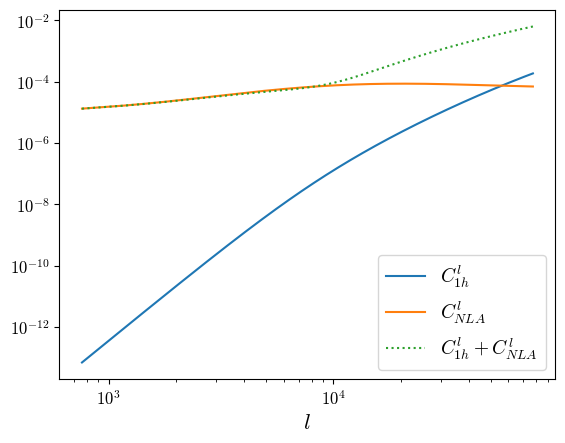

In [521]:
lfac = ell * (ell + 1) / (2 * np.pi)

plt.loglog(ell, lfac*Cl_gI_1h)
plt.loglog(ell, -lfac*Cl_gI_NLA)
plt.loglog(ell, -lfac*Cl_gI_windowed, ls=':')
plt.legend([r'$C^{l}_{1h}$', r'$C^{l}_{NLA}$', r'$C^{l}_{1h} + C^{l}_{NLA}$'],
          fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel(r'$l$', fontsize=16)

In [501]:
theta2 = np.geomspace(1, 250, 40)
y_IA = ccl.correlation(sp.zed.cosmo_SRD, ell, Cl_gI_windowed, theta2 / 60., type='NG')
y_IA_1h = ccl.correlation(sp.zed.cosmo_SRD, ell, Cl_gI_1h, theta2 / 60., type='NG',
                         method='legendre')
y_IA_NLA = ccl.correlation(sp.zed.cosmo_SRD, ell, Cl_gI_NLA, theta2 / 60., type='NG',
                          method='fftlog')
# bar_yIA = y_IA / (B_min1 + F_theta)
# bar_yIA_1h = y_IA_1h / (B_min1 + F_theta)
# bar_yIA_NLA = y_IA_NLA / (B_min1 + F_theta)

Text(0.5, 0, '$\\theta$ (arcmin)')

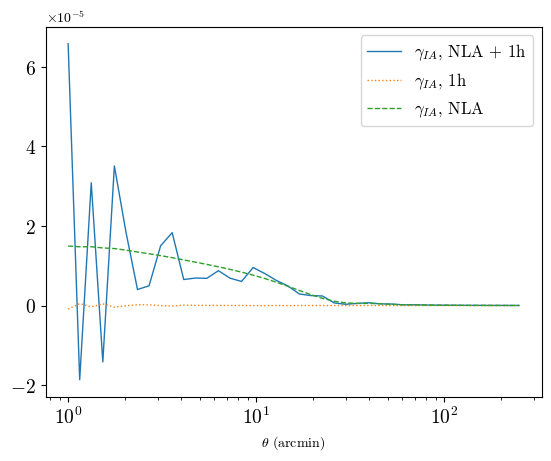

In [502]:
plt.plot(theta2, -y_IA, lw=1, ls='-')
plt.plot(theta2, -y_IA_1h, lw=1, ls=':')
plt.plot(theta2, -y_IA_NLA, lw=1, ls='--')
plt.legend([r'$\gamma_{IA}$, NLA + 1h', r'$\gamma_{IA}$, 1h', r'$\gamma_{IA}$, NLA'],
          fontsize=12)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xscale('log')
plt.xlabel(r'$\theta$ (arcmin)')